In [1]:
from IPython.display import display, Image
import os, warnings
import re
warnings.filterwarnings(action='ignore')
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from selenium.webdriver import ActionChains
import numpy as np
import pandas as pd

### 데이터 전처리
* 컬럼별 데이터 자료형 변환 및 데이터 정제
* Feature engineering 하기 (대륙명 데이터 추가, iso 국가 코드 flag icon에서 2자리 문자열 데이터로 변환)

In [43]:
data_df = pd.read_excel("./covid_df.xlsx")

In [44]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  221 non-null    int64  
 1   번호          221 non-null    int64  
 2   국가          221 non-null    object 
 3   확진자         221 non-null    object 
 4   사망자         221 non-null    object 
 5   완치          218 non-null    object 
 6   치명(%)       221 non-null    object 
 7   완치(%)       218 non-null    float64
 8   발생률         221 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 15.7+ KB


In [45]:
# 확진자 컬럼 데이터 정제

data_df["total_patients"] = data_df["확진자"].str.split("\n").str[0]
data_df["total_patients"] = data_df["total_patients"].apply(lambda x: x.replace(",", "")).astype(int)
data_df["total_patients"]

0      34434803
1      30027850
2      18056639
3       5760002
4       5381736
         ...   
216           4
217           4
218           3
219           2
220           1
Name: total_patients, Length: 221, dtype: int32

In [46]:
# 사망자 컬럼 데이터 정제

data_df["total_death"] = data_df["사망자"].str.split("\n").str[0]
data_df["total_death"] = data_df["total_death"].apply(lambda x: x.replace(",", "")).astype(int)
data_df["total_death"]

0      617875
1      390691
2      504897
3      110829
4       49293
        ...  
216         0
217         1
218         0
219         0
220         0
Name: total_death, Length: 221, dtype: int32

In [47]:
# Null 값이 있는 행 제거 (N/A 값이 있는 것은 제거)

data_df["total_recovered"] = data_df["완치"].str.split("\n").str[0]
data_df.dropna(inplace=True)
data_df["total_recovered"] = data_df["total_recovered"].apply(lambda x: x.replace(",", "")).astype(int)
print(data_df.shape)
data_df["total_recovered"]

(218, 12)


0      28817134
1      28987311
2      16388847
3       5575086
4       5242945
         ...   
216           4
217           3
218           3
219           2
220           1
Name: total_recovered, Length: 218, dtype: int32

In [48]:
# 치명율 데이터 정제

data_df["critical_rate"] = data_df["치명(%)"].apply(lambda x: x.replace("-", "0")).astype(float)
data_df["critical_rate"] = data_df["critical_rate"].apply(lambda x: x / 100)
data_df["critical_rate"]

0      0.018
1      0.013
2      0.028
3      0.019
4      0.009
       ...  
216    0.000
217    0.250
218    0.000
219    0.000
220    0.000
Name: critical_rate, Length: 218, dtype: float64

In [49]:
# 완치율 데이터 정제

data_df["recovery_rate"] = data_df["완치(%)"].astype(float)
data_df["recovery_rate"] = data_df["recovery_rate"].apply(lambda x: x / 100)
data_df["recovery_rate"]

0      0.837
1      0.965
2      0.908
3      0.968
4      0.974
       ...  
216    1.000
217    0.750
218    1.000
219    1.000
220    1.000
Name: recovery_rate, Length: 218, dtype: float64

In [50]:
# 100만명당 확진자 데이터 정제 (발생률)

data_df["patient_per_million"] = data_df["발생률"].apply(lambda x: x.replace(",", ""))
data_df["patient_per_million"] = data_df["patient_per_million"].apply(lambda x: x.replace("-", "0")).astype(int)
data_df["patient_per_million"]

0      104032
1       21759
2       84949
3       88244
4       63811
        ...  
216        68
217        13
218        15
219       329
220         9
Name: patient_per_million, Length: 218, dtype: int32

In [51]:
# 국가별 코드 데이터 컬럼 분리하여 코드명과 국가명 컬럼 추가

data_df["국가"] = data_df["국가"].apply(lambda x: x.replace("*", "")) # 일본 국가명에는 *이 들어가 있어서 처리
data_df["country_code"] = data_df["국가"].str[-2:].astype(str)
data_df["country_name"] = data_df["국가"].str[:-2].astype(str)
data_df["country_name"]

0          미국
1          인도
2         브라질
3         프랑스
4          터키
        ...  
216     마셜 제도
217      바누아투
218       사모아
219    세인트헬레나
220    미크로네시아
Name: country_name, Length: 218, dtype: object

In [52]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 0 to 220
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           218 non-null    int64  
 1   번호                   218 non-null    int64  
 2   국가                   218 non-null    object 
 3   확진자                  218 non-null    object 
 4   사망자                  218 non-null    object 
 5   완치                   218 non-null    object 
 6   치명(%)                218 non-null    object 
 7   완치(%)                218 non-null    float64
 8   발생률                  218 non-null    object 
 9   total_patients       218 non-null    int32  
 10  total_death          218 non-null    int32  
 11  total_recovered      218 non-null    int32  
 12  critical_rate        218 non-null    float64
 13  recovery_rate        218 non-null    float64
 14  patient_per_million  218 non-null    int32  
 15  country_code         218 non-null    obj

In [53]:
df_for_analysis = data_df.drop(["Unnamed: 0","번호", "국가", "확진자", "사망자", "완치", "치명(%)", "완치(%)", "발생률"], axis=1)
df_for_analysis = df_for_analysis.drop([215], axis=0) # 잔담 크루즈 행 정보 제거
df_for_analysis.tail(10)

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_code,country_name
210,27,0,27,0.00,1.000,33708,🇻🇦,바티칸 시국
211,26,0,25,0.00,0.962,4487,🇵🇲,생피에르 미클롱
212,20,1,19,0.05,0.950,4006,🇲🇸,몬트세랫
213,20,0,20,0.00,1.000,29,🇸🇧,솔로몬 제도
214,10,1,8,0.10,0.800,17,🇪🇭,서사하라
216,4,0,4,0.00,1.000,68,🇲🇭,마셜 제도
217,4,1,3,0.25,0.750,13,🇻🇺,바누아투
218,3,0,3,0.00,1.000,15,🇼🇸,사모아
219,2,0,2,0.00,1.000,329,🇸🇭,세인트헬레나
220,1,0,1,0.00,1.000,9,🇫🇲,미크로네시아


In [54]:
df_for_analysis.describe()

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million
count,2.170000e+02,217.000000,2.170000e+02,217.000000,217.000000,217.000000
mean,8.075031e+05,16944.838710,7.391667e+05,0.019862,0.874751,35091.608295
std,3.420621e+06,64931.619365,3.077350e+06,0.024848,0.181414,39674.530891
min,1.000000e+00,0.000000,1.000000e+00,0.000000,0.008000,0.000000
25%,6.630000e+03,94.000000,4.999000e+03,0.008000,0.873000,2493.000000
50%,4.973500e+04,852.000000,4.600000e+04,0.016000,0.950000,18828.000000
75%,3.556200e+05,5350.000000,3.296620e+05,0.024000,0.976000,62450.000000
max,3.443480e+07,617875.000000,2.898731e+07,0.250000,1.000000,179434.000000


In [55]:
iso_df = pd.read_excel("./iso_country_code.xlsx").rename(columns={"Unnamed: 3": "country_name", "Unnamed: 2": "country_iso_code"}, inplace=False)
iso_df = iso_df[["country_iso_code", "country_name"]]
iso_df = iso_df.drop([0, 1, 2], axis=0)
iso_df

,country_iso_code,country_name
3,GH,가나
4,GA,가봉
5,GY,가이아나
6,GM,감비아
7,GG,건지 섬
...,...,...
243,PH,필리핀
244,PN,핏케언 제도
245,HM,허드 맥도널드 제도
246,HU,헝가리


In [56]:
df_with_iso = pd.merge(df_for_analysis, iso_df, how='outer', on='country_name')
df_with_iso.dropna(subset=['country_code'], inplace=True)
df_with_iso.drop("country_code", axis=1, inplace=True)
df_with_iso

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_name,country_iso_code
0,34434803.0,617875.0,28817134.0,0.018,0.837,104032.0,미국,US
1,30027850.0,390691.0,28987311.0,0.013,0.965,21759.0,인도,IN
2,18056639.0,504897.0,16388847.0,0.028,0.908,84949.0,브라질,BR
3,5760002.0,110829.0,5575086.0,0.019,0.968,88244.0,프랑스,FR
4,5381736.0,49293.0,5242945.0,0.009,0.974,63811.0,터키,TR
...,...,...,...,...,...,...,...,...
212,4.0,0.0,4.0,0.000,1.000,68.0,마셜 제도,MH
213,4.0,1.0,3.0,0.250,0.750,13.0,바누아투,VU
214,3.0,0.0,3.0,0.000,1.000,15.0,사모아,WS
215,2.0,0.0,2.0,0.000,1.000,329.0,세인트헬레나,SH


In [57]:
continent_df = pd.read_csv("./country-and-continent-codes-list-csv.csv", encoding="utf-8")
continent_df = continent_df[["Continent_Name", "Two_Letter_Country_Code"]]
continent_df.rename(columns = {"Two_Letter_Country_Code": "country_iso_code", "Continent_Name": "continent_name"}, inplace=True)
continent_df

,continent_name,country_iso_code
0,Asia,AF
1,Europe,AL
2,Antarctica,AQ
3,Africa,DZ
4,Oceania,AS
...,...,...
257,Africa,ZM
258,Oceania,XX
259,Asia,XE
260,Asia,XD


In [58]:
final_df = pd.merge(df_with_iso, continent_df, how="left", left_on="country_iso_code", right_on="country_iso_code")
final_df.dropna(subset=["country_name"], inplace=True)
print(final_df.info())
final_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 0 to 223
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_patients       224 non-null    float64
 1   total_death          224 non-null    float64
 2   total_recovered      224 non-null    float64
 3   critical_rate        224 non-null    float64
 4   recovery_rate        224 non-null    float64
 5   patient_per_million  224 non-null    float64
 6   country_name         224 non-null    object 
 7   country_iso_code     202 non-null    object 
 8   continent_name       224 non-null    object 
dtypes: float64(6), object(3)
memory usage: 17.5+ KB
None


,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_name,country_iso_code,continent_name
0,34434803.0,617875.0,28817134.0,0.018,0.837,104032.0,미국,US,North America
1,30027850.0,390691.0,28987311.0,0.013,0.965,21759.0,인도,IN,Asia
2,18056639.0,504897.0,16388847.0,0.028,0.908,84949.0,브라질,BR,South America
3,5760002.0,110829.0,5575086.0,0.019,0.968,88244.0,프랑스,FR,Europe
4,5381736.0,49293.0,5242945.0,0.009,0.974,63811.0,터키,TR,Europe
...,...,...,...,...,...,...,...,...,...
219,4.0,0.0,4.0,0.000,1.000,68.0,마셜 제도,MH,Oceania
220,4.0,1.0,3.0,0.250,0.750,13.0,바누아투,VU,Oceania
221,3.0,0.0,3.0,0.000,1.000,15.0,사모아,WS,Oceania
222,2.0,0.0,2.0,0.000,1.000,329.0,세인트헬레나,SH,Africa


In [60]:
final_df.to_excel("preprocessed_df.xlsx", index=False)

### 데이터 시각화 (Exploratory data analysis)
* seaborn 라이브러리를 활용하여 컬럼별 데이터 간의 상관관계 파악
* 데이터의 분포 및 특성 확인

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
final_df.shape # 데이터 개수 파악

(227, 9)

In [82]:
final_df = final_df.reset_index(drop=True)
final_df

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_name,country_iso_code,continent_name
0,34419838.0,617463.0,28767507.0,0.018,0.836,103987.0,미국,US,North America
1,29977861.0,389302.0,28926038.0,0.013,0.965,21723.0,인도,IN,Asia
2,17969806.0,502817.0,16288392.0,0.028,0.906,84540.0,브라질,BR,South America
3,5757798.0,110778.0,5566394.0,0.019,0.967,88210.0,프랑스,FR,Europe
4,5375593.0,49236.0,5237731.0,0.009,0.974,63738.0,터키,TR,Europe
...,...,...,...,...,...,...,...,...,...
222,4.0,0.0,4.0,0.000,1.000,68.0,마셜 제도,MH,Oceania
223,4.0,1.0,3.0,0.250,0.750,13.0,바누아투,VU,Oceania
224,3.0,0.0,3.0,0.000,1.000,15.0,사모아,WS,Oceania
225,2.0,0.0,2.0,0.000,1.000,329.0,세인트헬레나,SH,Africa


['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
[1254373.0, 1470201.0, 3737049.0, 925818.0, 70759.0, 794886.0]


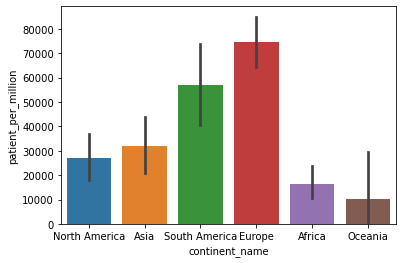

In [83]:
import numpy as np

# 대륙별 확진자 수 비교 그래프 (100만명 당 환자수 기준)

continent_group = final_df.groupby('continent_name')['patient_per_million'].sum()
continent_category = continent_group.index.tolist()
continent_data = continent_group.tolist()

print(continent_category)
print(continent_data)

sns.barplot(x="continent_name", y="patient_per_million", data=final_df)
plt.show()

['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
[6581517.0, 59057603.0, 54109211.0, 40346279.0, 23993.0, 31730020.0]


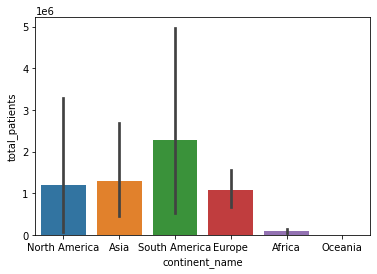

In [105]:
# 대륙별 확진자 수 비교 그래프 (절대 환자 수)

continent_group = final_df.groupby('continent_name')['total_patients'].sum()
continent_category = continent_group.index.tolist()
continent_data = continent_group.tolist()

print(continent_category)
print(continent_data)

sns.barplot(x="continent_name", y="total_patients", data=final_df)
plt.show()

In [88]:
# 인구수 100만명당 환자수 기준으로 상위 10개 국가

final_df.sort_values(by="patient_per_million", ascending=False)[:10]

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_name,country_iso_code,continent_name
151,13864.0,127.0,13665.0,0.009,0.986,179434.0,안도라,AD,Europe
102,100092.0,1605.0,98189.0,0.016,0.981,159365.0,몬테네그로,ME,Europe
22,1666192.0,30283.0,1633482.0,0.018,0.980,155588.0,체코,CZ,Europe
73,263295.0,1311.0,254913.0,0.005,0.968,154736.0,바레인,BH,Asia
178,5090.0,90.0,4999.0,0.018,0.982,150010.0,산마리노,SM,Europe
148,14620.0,59.0,13323.0,0.004,0.911,148657.0,세이셸,SC,Africa
114,72149.0,206.0,67148.0,0.003,0.931,133475.0,몰디브,MV,Asia
181,4323.0,94.0,4214.0,0.022,0.975,128313.0,지브롤터,GI,Europe
75,257066.0,4416.0,251243.0,0.017,0.977,123653.0,슬로베니아,SI,Europe
115,70535.0,818.0,69459.0,0.012,0.985,112680.0,룩셈부르크,LU,Europe


In [89]:
# 절대 환자수 기준으로 상위 10개 국가

final_df.sort_values(by="total_patients", ascending=False)[:10]

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_name,country_iso_code,continent_name
0,34419838.0,617463.0,28767507.0,0.018,0.836,103987.0,미국,US,North America
1,29977861.0,389302.0,28926038.0,0.013,0.965,21723.0,인도,IN,Asia
2,17969806.0,502817.0,16288392.0,0.028,0.906,84540.0,브라질,BR,South America
3,5757798.0,110778.0,5566394.0,0.019,0.967,88210.0,프랑스,FR,Europe
4,5375593.0,49236.0,5237731.0,0.009,0.974,63738.0,터키,TR,Europe
5,5375593.0,49236.0,5237731.0,0.009,0.974,63738.0,터키,TR,Asia
6,5350919.0,130347.0,4889450.0,0.024,0.914,36667.0,러시아,RU,Europe
7,5350919.0,130347.0,4889450.0,0.024,0.914,36667.0,러시아,RU,Asia
8,4640507.0,127981.0,4303996.0,0.028,0.927,68357.0,영국,GB,Europe
9,4277395.0,89490.0,3910835.0,0.021,0.914,94641.0,아르헨티나,AR,South America


In [91]:
# 회복률 높은 순으로 정렬

final_df.sort_values(by="recovery_rate", ascending=False)[:15]

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_name,country_iso_code,continent_name
226,1.0,0.0,1.0,0.000,1.000,9.0,미크로네시아,NaN,Africa
225,2.0,0.0,2.0,0.000,1.000,329.0,세인트헬레나,SH,Africa
224,3.0,0.0,3.0,0.000,1.000,15.0,사모아,WS,Oceania
222,4.0,0.0,4.0,0.000,1.000,68.0,마셜 제도,MH,Oceania
220,20.0,0.0,20.0,0.000,1.000,29.0,솔로몬 제도,SB,Oceania
217,27.0,0.0,27.0,0.000,1.000,33708.0,바티칸 시국,VA,Europe
214,63.0,0.0,63.0,0.000,1.000,18103.0,포클랜드 제도,FK,South America
213,109.0,0.0,109.0,0.000,1.000,7265.0,앵귈라,AI,North America
117,62448.0,35.0,62070.0,0.001,0.994,10674.0,싱가포르,SG,Asia
211,161.0,1.0,160.0,0.006,0.994,1431.0,그레나다,GD,North America


In [94]:
# 사망률 높은 순으로 정렬

final_df.sort_values(by="critical_rate", ascending=False)[:15]

,total_patients,total_death,total_recovered,critical_rate,recovery_rate,patient_per_million,country_name,country_iso_code,continent_name
223,4.0,1.0,3.0,0.250,0.750,13.0,바누아투,VU,Oceania
171,6889.0,1355.0,3958.0,0.197,0.575,231.0,예멘,YE,Asia
221,10.0,1.0,8.0,0.100,0.800,17.0,서사하라,EH,Africa
18,2030611.0,190645.0,0.0,0.094,0.000,61586.0,페루,PE,South America
16,2478551.0,231244.0,1974255.0,0.093,0.797,19224.0,멕시코,MX,North America
126,36347.0,2737.0,30062.0,0.075,0.827,829.0,수단,SD,Africa
135,25158.0,1848.0,21747.0,0.073,0.864,1438.0,시리아,SY,Asia
70,277797.0,15898.0,206053.0,0.057,0.742,2715.0,이집트,EG,Africa
147,14867.0,775.0,7204.0,0.052,0.485,935.0,소말리아,SO,Africa
106,91629.0,4636.0,86481.0,0.051,0.944,64.0,중국,NaN,Africa


In [128]:
# 국가별 순위 정보를 시각화하기

country_with_rank = final_df[["country_name", "patient_per_million"]]
country_with_rank = country_with_rank.sort_values(by=["patient_per_million"], ascending=False)[:50]
country_with_rank = country_with_rank.set_index("country_name")

<AxesSubplot:ylabel='country_name'>

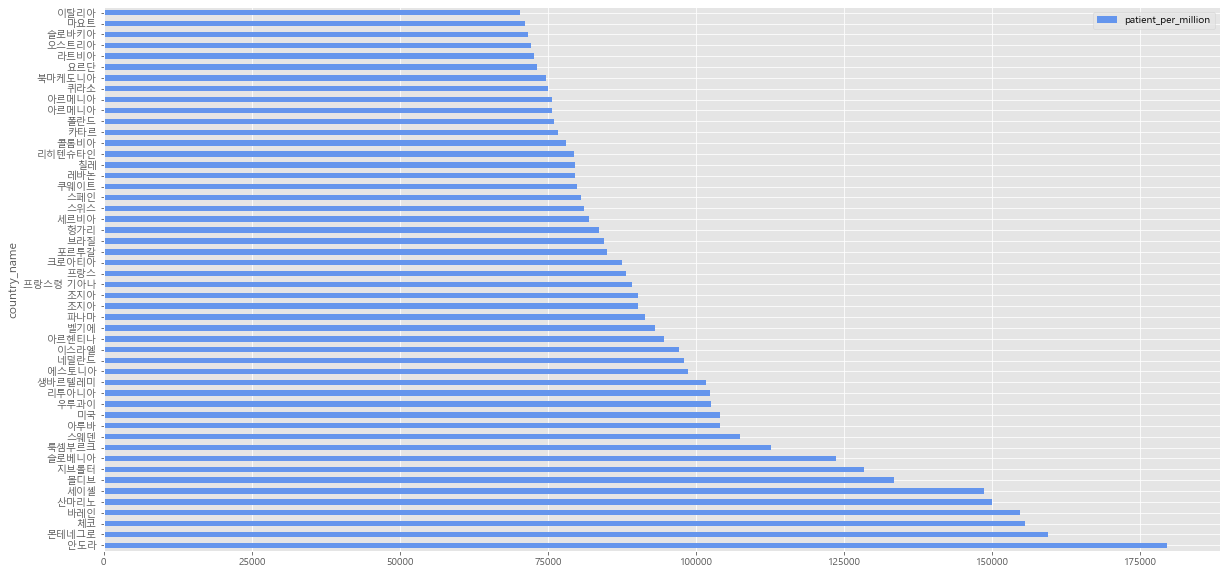

In [129]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.style.use('ggplot')
country_with_rank.plot(kind='barh', color='cornflowerblue', width=0.5, figsize=(20, 10))